# Discounted Cash Flow
## Fair Stock Valuation Method
### Step 1: Forecast Free Cash Flows (FCF)
$$ \text{Free Cash Flow} = \text{Operating Cash Flow} - \text{Capital Expenditures} $$

Matplotlib is building the font cache; this may take a moment.


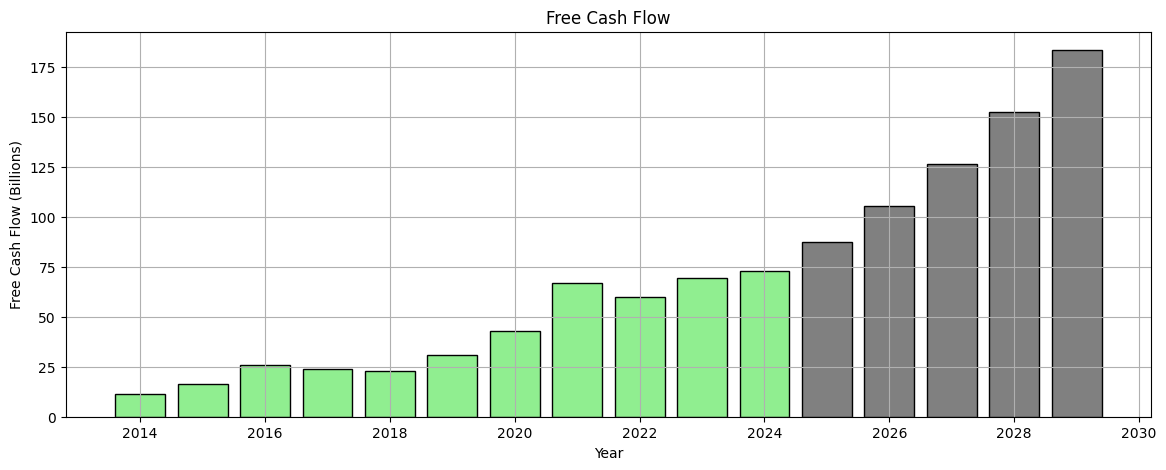

In [2]:
from matplotlib import pyplot as plt
def cagr(start, finish, n_years):
    return ((finish / start)**(1/n_years)) - 1

fcf_blns = { 
    2024: 72.76, 
    2023: 69.5, 
    2022: 60.01, 
    2021: 67.01, 
    2020: 42.84, 
    2019: 30.97,
    2018: 22.83,
    2017: 23.91,
    2016: 25.82,
    2015: 16.62,
    2014: 11.42}
start_year = 2014
end_year = 2024
last_proj_year = 2029
last_fcf = fcf_blns[end_year]
fcf_cagr = cagr(start=fcf_blns[start_year], finish=fcf_blns[end_year], n_years=end_year - start_year)
fcf_projections_blns = {
    2025: last_fcf * (1 + fcf_cagr),
    2026: last_fcf * (1 + fcf_cagr)**2,
    2027: last_fcf * (1 + fcf_cagr)**3,
    2028: last_fcf * (1 + fcf_cagr)**4,
    2029: last_fcf * (1 + fcf_cagr)** 5
}
all_fcf_blns = fcf_blns | fcf_projections_blns
colors = ['gray' if year > end_year else 'lightgreen' for year in all_fcf_blns.keys()]
plt.figure(figsize=(14, 5))
plt.title("Free Cash Flow")
plt.bar(all_fcf_blns.keys(), all_fcf_blns.values(), color=colors, edgecolor='black')
plt.xlabel("Year")
plt.ylabel("Free Cash Flow (Billions)")
plt.grid()


### Step 2: Get Discount Rate
#### 2.A: Calculate Cost of Equity
$$ r_e = R_f + \beta \times (R_m - R_f) $$
- $ R_f $ = Risk free rate
- $ \beta $ = Stock beta
- $ R_m $ = Expected market return



In [3]:
def get_cost_of_equity(risk_free_rate, expected_return, stock_beta):
    erf = expected_return - risk_free_rate
    return (risk_free_rate + stock_beta * erf)

#### 2.B: Calculate Cost of Debt
$$ r_a = \frac{\text{Interest Expense}}{\text{Total Debt}} $$


In [4]:
def get_cost_of_debt(interest_expense, total_debt):
    return interest_expense / total_debt

#### 2.C: Calculate the Weighted Average Cost of Capital
$$ \text{WACC} = (\frac{E}{V} \times r_e) + (\frac{D}{V} \times r_d \times (1 - T)) $$
- $ E = \text{Share Price} \times \text{Shares Outstanding} $ = Market value of equity
- $ D $ = Market value of debt
- $ V = E + D $ = Total value of capital
- $ r_e $ = Cost of equity
- $ r_d $ = Cost of debt
- $ T $ = Corporate tax rate

In [5]:
def get_wacc(share_price, shares_outstanding, total_debt, interest_expense, tax_rate, risk_free_rate, expected_return, stock_beta):
    equity_value = share_price * shares_outstanding
    total_capital = equity_value + total_debt
    cost_of_debt = get_cost_of_debt(interest_expense, total_debt)
    cost_of_equity = get_cost_of_equity(risk_free_rate, expected_return, stock_beta)
    equity_weight = equity_value / total_capital
    debt_weight = total_debt / total_capital
    return (equity_weight * cost_of_equity) + (debt_weight * cost_of_debt * (1 - tax_rate))

wacc = get_wacc(
    share_price=176.79, 
    shares_outstanding=5_800_000_000, 
    total_debt=28_500_000_000, 
    interest_expense=-438_000_000,
    tax_rate=0.15, 
    risk_free_rate=0.0412, 
    expected_return=0.10, 
    stock_beta=0.95)

### Step 3: Calculate the Present Value (PV) of Each Year's FCF
$$ \text{Present Value} = \frac{\text{FCF}_t}{(1+r)^t} $$

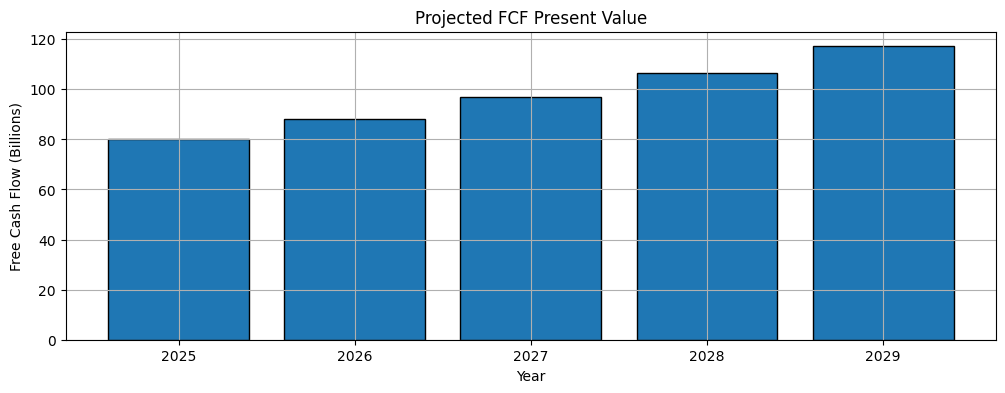

In [6]:
fcf_proj_pv_blns = {}

for k, v in fcf_projections_blns.items():
    pv = v / ((1 + wacc) ** (k - end_year))
    fcf_proj_pv_blns[k] = pv

plt.figure(figsize=(12, 4))
plt.title("Projected FCF Present Value")
plt.bar(fcf_proj_pv_blns.keys(), fcf_proj_pv_blns.values(), edgecolor='k')
plt.xlabel("Year")
plt.ylabel("Free Cash Flow (Billions)")
plt.grid()

### Step 4: Calculate Terminal Value (TV)
$$ \text{Terminal Value} = \frac{\text{FCF}_\text{final} \times (1 + g)}{r - g} $$
- $ r $ = Discount rate
- $ g $ = Terminal growth rate
$$ \text{PV}_\text{TV} = \frac{\text{TV}}{(1 + r)^t} $$

In [10]:
const_growth = 0.05
tv = ((fcf_projections_blns[last_proj_year]*1_000_000_000) * (1 + const_growth)) / (wacc - const_growth)
pv_tv = tv / (1 + wacc) ** (last_proj_year - end_year + 1)
print(tv)
print(pv_tv)

4374560773296.3535
2550558728166.578


### Step 5: Add All Present Values
$$ \text{Discounted Cash Flow} = \sum_{t=1}^n \frac{\text{FCF}_t}{(1 + r)^t} + \frac{\text{TV}}{(1 + r)^n} $$

### Step 6: Adjust for Net Debt
$$ \text{Net Debt} = \text{Total Debt} - \text{Cash} $$
$$ \text{Fair Equity Value} = \text{DCF} - \text{Net Debt} $$


### Step 7: Divide by Shares Outstanding
$$ \text{Fair Value} = \frac{\text{Fair Equity Value}}{\text{Shares Outstanding}} $$